In [36]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import seaborn as sns
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.utils import plot_model


In [37]:
data_dir = '/content/drive/MyDrive/Desertation/CTSCAN'
disease_types = ['COVID', 'non-COVID']
image_size = 224
batch_size = 32
epochs = 10
seed = 40

In [38]:
train_data = []
for index, disease_type in enumerate(disease_types):
    disease_dir = os.path.join(data_dir, disease_type)
    for file in os.listdir(disease_dir):
        train_data.append([os.path.join(disease_dir, file), index, disease_type])

train_df = pd.DataFrame(train_data, columns=['File', 'ID', 'Disease Type'])
train_df = train_df.sample(frac=1, replace=False, random_state=seed).reset_index(drop=True)


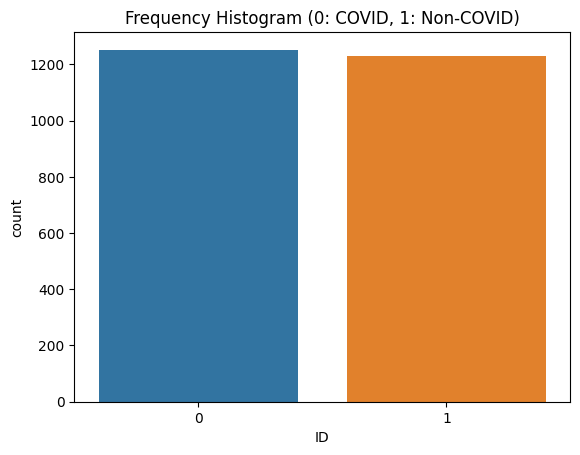

In [39]:
sns.countplot(x='ID', data=train_df).set_title("Frequency Histogram (0: COVID, 1: Non-COVID)")
plt.show()


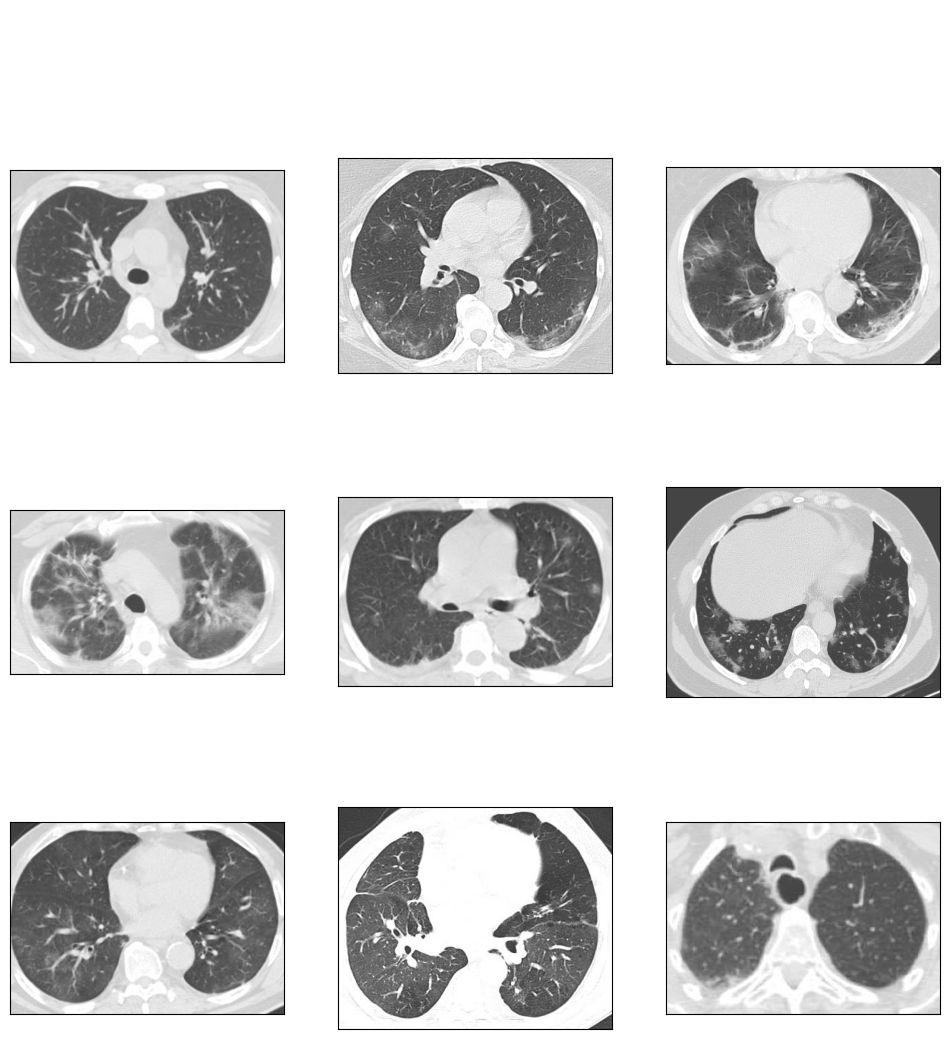

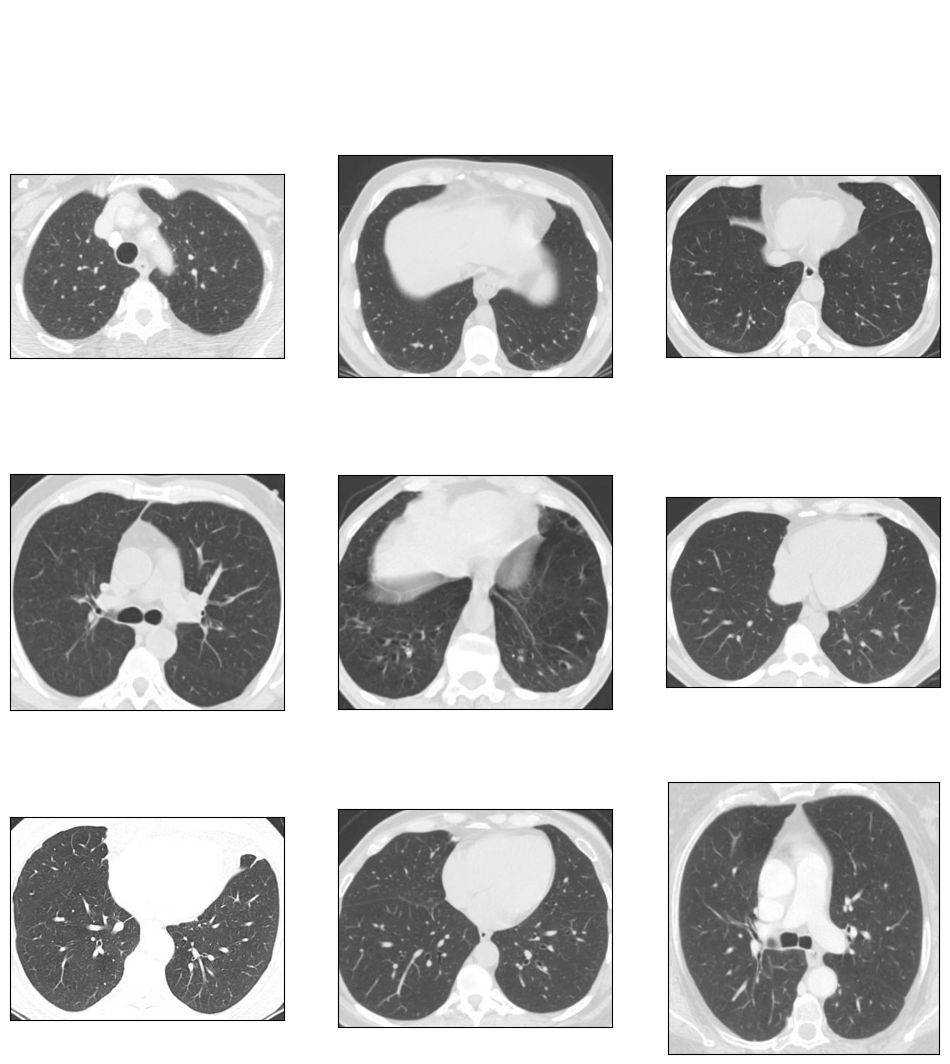

In [40]:
def plot_defects(defect_type, rows, cols):
    fig, ax = plt.subplots(rows, cols, figsize=(12, 12))
    defect_files = train_df['File'][train_df['Disease Type'] == defect_type].values

    n = 0
    fig.suptitle(defect_type, fontsize=22, color="white")
    for i in range(rows):
        for j in range(cols):
            image_path = defect_files[n]
            ax[i, j].set_xticks([])
            ax[i, j].set_yticks([])
            ax[i, j].imshow(cv2.imread(image_path))
            n += 1

plot_defects('COVID', 3, 3)
plot_defects('non-COVID', 3, 3)


In [41]:
def read_image(filepath):
    image = cv2.imread(filepath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    return image

def resize_image(image, image_size):
    image = cv2.resize(image, (image_size, image_size), interpolation=cv2.INTER_AREA)
    return image

X_train = np.zeros((train_df.shape[0], image_size, image_size, 3))

for i, file in enumerate(train_df['File'].values):
    image = read_image(file)
    if image is not None:
        image = resize_image(image, image_size)
        X_train[i] = image

X_train = X_train / 255.0
Y_train = to_categorical(train_df['ID'].values, num_classes=2)


In [42]:
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=seed)


In [43]:
datagen = ImageDataGenerator(rotation_range=360, width_shift_range=0.2, height_shift_range=0.2,
                             zoom_range=0.2, horizontal_flip=True, vertical_flip=True)
datagen.fit(X_train)


In [44]:
from tensorflow.keras.applications import Xception
def build_xception(image_size, channels):
    base_model = Xception(weights='imagenet', include_top=False, input_shape=(image_size, image_size, channels))
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x =Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    output = Dense(2, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=output)
    return model

model = build_xception(image_size, 3)
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 111, 111, 32  864         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 111, 111, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                           

In [46]:
annealer = ReduceLROnPlateau(monitor='val_accuracy', factor=0.70, patience=5, verbose=1, min_lr=1e-4)
checkpoint = ModelCheckpoint('model.h5', verbose=1, save_best_only=True)
import time
start_time = time.time()


history = model.fit(datagen.flow(X_train, Y_train, batch_size=batch_size),
                    steps_per_epoch=X_train.shape[0] // batch_size,
                    epochs=epochs,
                    verbose=1,
                    callbacks=[annealer, checkpoint],
                    validation_data=(X_val, Y_val))
end_time = time.time()
total_time = end_time - start_time
frame_rate = len(X_val) / total_time

print(f"Frame Rate: {frame_rate:.2f} samples/s")



Epoch 1/10
62/62 [==============================] - ETA: 0s - loss: 0.4135 - accuracy: 0.8342
Epoch 1: val_loss improved from inf to 0.84024, saving model to model.h5
62/62 [==============================] - 21s 337ms/step - loss: 0.4135 - accuracy: 0.8342 - val_loss: 0.8402 - val_accuracy: 0.8048 - lr: 0.0010
Epoch 2/10
62/62 [==============================] - ETA: 0s - loss: 0.3241 - accuracy: 0.8745
Epoch 2: val_loss improved from 0.84024 to 0.60987, saving model to model.h5
62/62 [==============================] - 21s 339ms/step - loss: 0.3241 - accuracy: 0.8745 - val_loss: 0.6099 - val_accuracy: 0.7103 - lr: 0.0010
Epoch 3/10
62/62 [==============================] - ETA: 0s - loss: 0.2791 - accuracy: 0.8896
Epoch 3: val_loss did not improve from 0.60987
62/62 [==============================] - 20s 322ms/step - loss: 0.2791 - accuracy: 0.8896 - val_loss: 0.7457 - val_accuracy: 0.6600 - lr: 0.0010
Epoch 4/10
62/62 [==============================] - ETA: 0s - loss: 0.2536 - accuracy:

16/16 [==============================] - 1s 18ms/step
Accuracy: 0.9336016096579477
Precision: 0.9868421052631579
Recall: 0.8823529411764706
F1 Score: 0.9316770186335402
ROC AUC Score: 0.9911521633446767
Confusion Matrix:
 [[239   3]
 [ 30 225]]
Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.99      0.94       242
           1       0.99      0.88      0.93       255

    accuracy                           0.93       497
   macro avg       0.94      0.93      0.93       497
weighted avg       0.94      0.93      0.93       497

Validation Loss: 0.18083861470222473


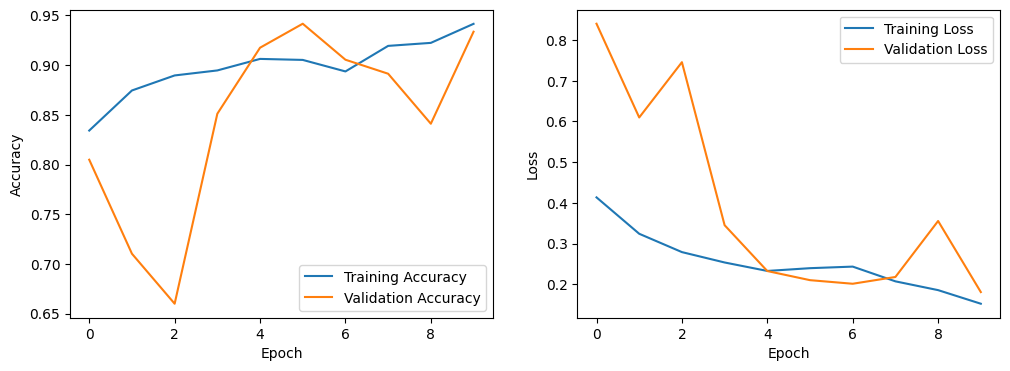

True Positive: 225
False Negative: 30
True Negative: 239
False Positive: 3
True Positive Rate: 0.8823529411764706
True Negative Rate: 0.987603305785124



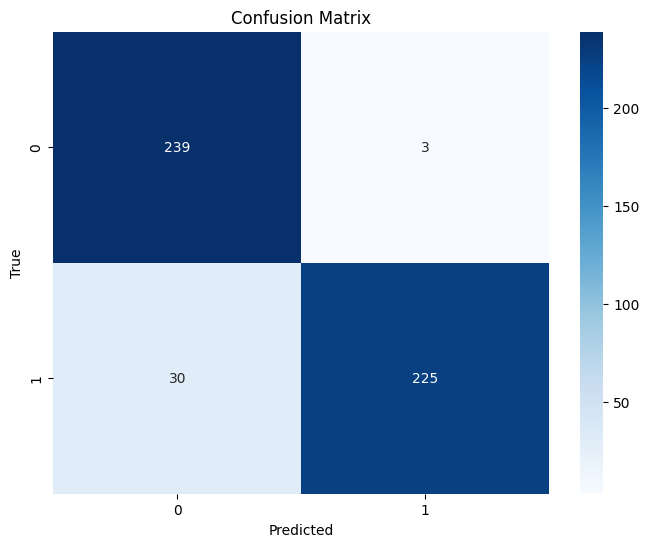

In [47]:
from sklearn.metrics import confusion_matrix


from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report, mean_squared_error, r2_score
  #Calculate evaluation metrics
y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)

accuracy = accuracy_score(np.argmax(Y_val, axis=1), y_pred_classes)
precision = precision_score(np.argmax(Y_val, axis=1), y_pred_classes)
recall = recall_score(np.argmax(Y_val, axis=1), y_pred_classes)
f1 = f1_score(np.argmax(Y_val, axis=1), y_pred_classes)
roc_auc = roc_auc_score(Y_val, y_pred)
cm = confusion_matrix(np.argmax(Y_val, axis=1), y_pred_classes)
classification_rep = classification_report(np.argmax(Y_val, axis=1), y_pred_classes)
loss_val = model.evaluate(X_val, Y_val, verbose=0)[0]

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("ROC AUC Score:", roc_auc)
print("Confusion Matrix:\n", cm)
print("Classification Report:\n", classification_rep)
print("Validation Loss:", loss_val)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

TP = cm[1][1]
print(f"True Positive: {TP}")

FN = cm[1][0]
print(f"False Negative: {FN}")

TN = cm[0][0]
print(f"True Negative: {TN}")

FP = cm[0][1]
print(f"False Positive: {FP}")

# Sensitivity, recall, or true positive rate
print(f"True Positive Rate: {TP / (TP + FN)}")

# Specificity or true negative rate
print(f"True Negative Rate: {TN / (TN + FP)}\n")
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

from sklearn.metrics import precision_recall_curve, auc

# Calculate the confusion matrix
conf_matrix = confusion_matrix(np.argmax(Y_val, axis=1), y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


1/1 [==============================] - 1s 767ms/step


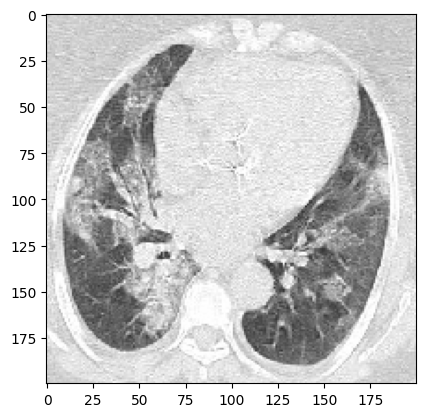

The image contains COVID-19


In [48]:
from tensorflow.keras.preprocessing import image
from keras.models import load_model
import numpy as np

# Load model
model = load_model('model.h5')

# Load and preprocess image
img = image.load_img('/content/drive/MyDrive/Desertation/CTSCAN/COVID/Covid (1014).png', grayscale = False, target_size = (image_size, image_size))
show_img = image.load_img('/content/drive/MyDrive/Desertation/CTSCAN/COVID/Covid (1014).png', grayscale = False, target_size = (200, 200))
disease_class = ['Covid-19','Non Covid-19']
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = x / 255.0

# Make prediction
prediction = model.predict(x)
plt.imshow(show_img)
plt.show()
# Determine result
if prediction[0][0] > 0.5:
    print("The image contains COVID-19")
else:
    print("The image does not contain COVID-19")